In [ ]:
# !pip install statsmodels

In [390]:
import numpy as np 
import pandas as pd
from datetime import datetime
import os
import re

from scipy.stats import f_oneway, levene
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")


In [2]:
filename = 'gridwatch-all.csv'
path = './dataset/'
path + filename

'./dataset/gridwatch-all.csv'

In [3]:
df = pd.read_csv(path + filename)
df.shape

(1372758, 26)

In [4]:
df.head()

,id,timestamp,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,...,irish_ict,ew_ict,nemo,other,north_south,scotland_england,ifa2,intelec_ict,nsl,vkl_ict
0,4,2011-05-27 15:50:04,38874,50.132000,9316,8221,18239,1253,309,636,...,-414,0.0,0,0,0,0,0,0,0,0
1,5,2011-05-27 15:55:02,38845,50.091000,9294,8225,18158,1304,332,633,...,-414,0.0,0,0,0,0,0,0,0,0
2,6,2011-05-27 16:00:02,38745,50.034000,9270,8224,18110,1322,285,634,...,-414,0.0,0,0,0,0,0,0,0,0
3,7,2011-05-27 16:05:01,38826,49.990002,9262,8220,18114,1364,287,635,...,-414,0.0,0,0,0,0,0,0,0,0
4,8,2011-05-27 16:10:02,38865,50.016998,9256,8210,18107,1370,297,637,...,-414,0.0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372758 entries, 0 to 1372757
Data columns (total 26 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1372758 non-null  int64  
 1    timestamp         1372758 non-null  object 
 2    demand            1372758 non-null  int64  
 3    frequency         1372758 non-null  float64
 4    coal              1372758 non-null  int64  
 5    nuclear           1372758 non-null  int64  
 6    ccgt              1372758 non-null  int64  
 7    wind              1372758 non-null  int64  
 8    pumped            1372758 non-null  int64  
 9    hydro             1372758 non-null  int64  
 10   biomass           1372758 non-null  int64  
 11   oil               1372758 non-null  int64  
 12   solar             1372758 non-null  float64
 13   ocgt              1372758 non-null  int64  
 14   french_ict        1372758 non-null  int64  
 15   dutch_ict         1372758 non-n

Notes:

1. Good thing all the features are numeric

### Clean up

1. Some columns have whitespaces. To remove them for consistency

In [6]:
df.columns

Index(['id', ' timestamp', ' demand', ' frequency', ' coal', ' nuclear',
       ' ccgt', ' wind', ' pumped', ' hydro', ' biomass', ' oil', ' solar',
       ' ocgt', ' french_ict', ' dutch_ict', ' irish_ict', ' ew_ict', ' nemo',
       ' other', ' north_south', ' scotland_england', ' ifa2', ' intelec_ict',
       ' nsl', ' vkl_ict'],
      dtype='object')

In [7]:
df.columns = [i.strip() for i in df.columns]
df.columns

Index(['id', 'timestamp', 'demand', 'frequency', 'coal', 'nuclear', 'ccgt',
       'wind', 'pumped', 'hydro', 'biomass', 'oil', 'solar', 'ocgt',
       'french_ict', 'dutch_ict', 'irish_ict', 'ew_ict', 'nemo', 'other',
       'north_south', 'scotland_england', 'ifa2', 'intelec_ict', 'nsl',
       'vkl_ict'],
      dtype='object')

In [8]:
# convert to timestamp 
df['timestamp_og'] = pd.to_datetime(df['timestamp'])
df['timestamp_day'] = df['timestamp_og'].dt.strftime('%Y-%m-%d') # to day
df['timestamp_week'] = (df['timestamp_og'] - pd.to_timedelta(df['timestamp_og'].dt.weekday, unit='D')).dt.strftime('%Y-%m-%d')# to week
df['timestamp_month'] = df['timestamp_og'].dt.strftime('%Y-%m-01') # to month
df['timestamp_year'] = df['timestamp_og'].dt.strftime('%Y-01-01') # to year


In [9]:
# sort by date 
df.sort_values(by='timestamp_og', ascending=True, inplace=True)

In [124]:
# function to plot counts
def plot_timeseries_count(
        df: pd.DataFrame,
        time_variable: str,
        show_xticks: bool = True
):
    """ 
    Plot bar chart (counts) for specified variable

    """
    # check variables are available 
    assert time_variable in df.columns, "Specified variables not found in df"

    # perform groupby 
    df = df.groupby(time_variable).size().reset_index().rename(columns={0: 'count'})

    print(f"------ Earliest date: {df[time_variable].min()}; Latest date: {df[time_variable].max()}------")

    # plot 
    plt.figure(figsize=(8, 3))
    sns.barplot(data=df, x=time_variable, y='count')
    plt.title(f"Count of demand over {time_variable.split('_')[-1]}", fontsize=8)
    plt.ylabel(f"Count", fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(f"{time_variable}", fontsize=8)
    if show_xticks==True:
        plt.xticks(rotation=45, fontsize=8)
    else:
        plt.xticks('')
    plt.show();

------ Earliest date: 2011-01-01; Latest date: 2024-01-01------


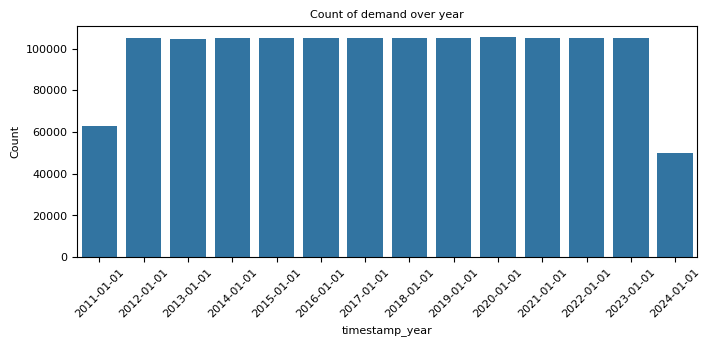

------ Earliest date: 2011-05-01; Latest date: 2024-06-01------


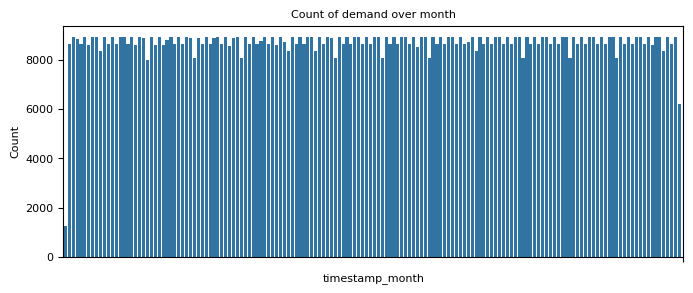

------ Earliest date: 2011-05-27; Latest date: 2024-06-22------


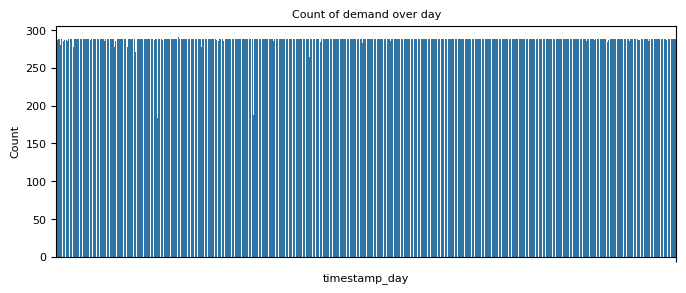

In [125]:
# year, month, week 
for i in [('timestamp_year', True), ('timestamp_month', False), ('timestamp_day', False)]:
    plot_timeseries_count(df=df, time_variable=i[0], show_xticks=i[1])

### Visualise total demand over time

1. Using sum of demand instead of mean

In [108]:
# function to plot time series 
def plot_timeseries_overtime(
        df: pd.DataFrame,
        time_variable: str,
        variable: str,
        show_xticks: bool = True
):
    """ 
    Plot time-series chart for specified variable

    """
    # check variables are available 
    assert time_variable in df.columns and variable in df.columns, "Specified variables not found in df"

    # perform groupby 
    if '_' in time_variable:
        df = df.groupby(time_variable)[variable].sum().reset_index()
    else:
        pass 

    # plot
    plt.figure(figsize=(8, 3))
    sns.scatterplot(data=df, x=time_variable, y=variable)
    plt.title(f"Demand over {time_variable.split('_')[-1]}s", fontsize=8)
    plt.ylabel(f"Demand", fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(f"{time_variable}", fontsize=8)
    if show_xticks==True:
        plt.xticks(rotation=45, fontsize=8)
    else:
        plt.xticks('')
    plt.show();
    

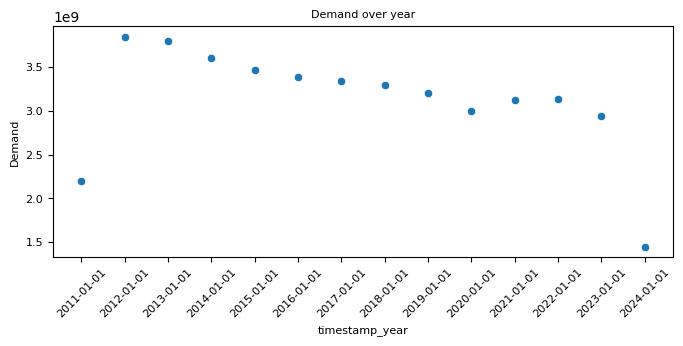

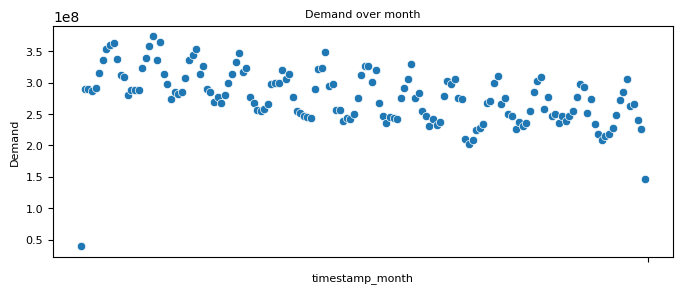

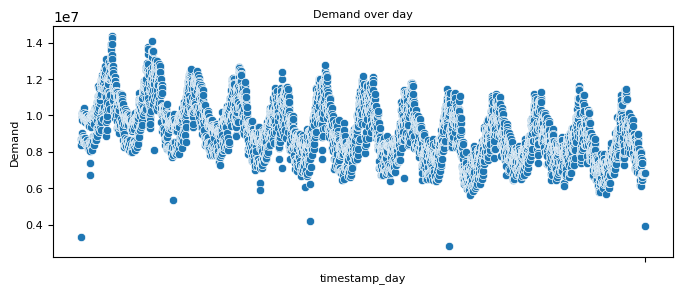

In [111]:
# year, month, week 
for i in [('timestamp_year', True), ('timestamp_month', False), ('timestamp_day', False)]:
    plot_timeseries_overtime(df=df, time_variable=i[0], variable='demand', show_xticks=i[1])

Notes:

1. It's clear from the charts that there is a downward trend to demand on all time scales, over time, indicating non-stationarity
2. There is also strong evidence of seasonality  

### Summary statistics

1. Split time-series into multiple parts
2. Calculate mean and variance for each part
3. Mean and variance would be different in a non-stationary time-series

In [116]:
# function to calculate mean and variance 
def calculate_summary_stats(
        df: pd.DataFrame,
        time_variable: str,
        variable: str,
        n_splits: int = 5
):
    """ 
    Split df into multiple parts and calculate the mean and variance of each part

    """
    # check variables are available 
    assert time_variable in df.columns and variable in df.columns, "Specified variables not found in df"

    # groupby 
    if '_' in time_variable:
        df = df.groupby(time_variable)[variable].sum().reset_index().reset_index().rename(columns={'index': 'id'})
    else:
        pass

    # max and min demand value 
    max_demand = df['demand'].max() 
    min_demand = df['demand'].min()
    xticks = np.linspace(min_demand, max_demand, 10)
    if '_' in time_variable:
        scale = time_variable.split('_')[-1]
    else:
        pass

    # split data using numpy 
    split_df = np.array_split(df, n_splits)
    
    # store summary statistics
    store_mean = []
    store_var = []

    for i in range(n_splits):
        print(f"------ Starting from index: {split_df[i]['id'].min():,}; Size: {len(split_df[i]):,} ------")
        mean = int(split_df[i]['demand'].mean())
        var = int(split_df[i]['demand'].var())
        # append 
        store_mean.append(mean)
        store_var.append(var)
        # plot distribution
        plt.figure(figsize=(8,3))
        sns.histplot(data=split_df[i], x='demand', bins=50)
        plt.title(f"Distribution of demand over {scale}s", fontsize=8)
        plt.ylabel(f"Count", fontsize=8)
        plt.xlabel(f"Demand", fontsize=8)
        plt.xticks(xticks, fontsize=8)
        plt.axvline(x=mean, color='black', linestyle='--') # mean 
        plt.show()
    
    print(f"Mean values for each split: {store_mean}")
    print(f"Variance values for each split: {store_var} \n")
    

/opt/anaconda3/envs/bigpay/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


------ Starting from index: 0; Size: 7 ------


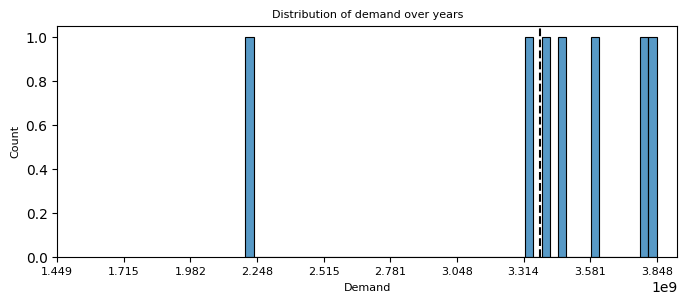

------ Starting from index: 7; Size: 7 ------


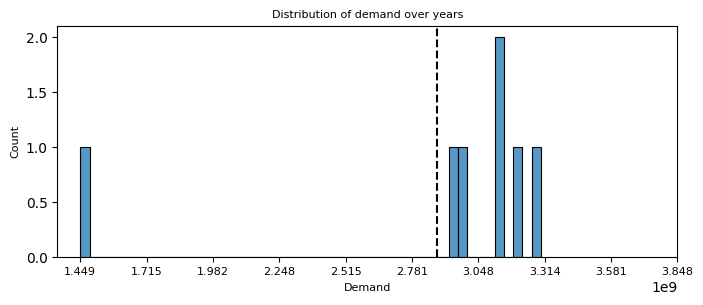

Mean values for each split: [3378947577, 2880275831]
Variance values for each split: [306936561165680256, 412617631911935168] 

------ Starting from index: 0; Size: 53 ------


/opt/anaconda3/envs/bigpay/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


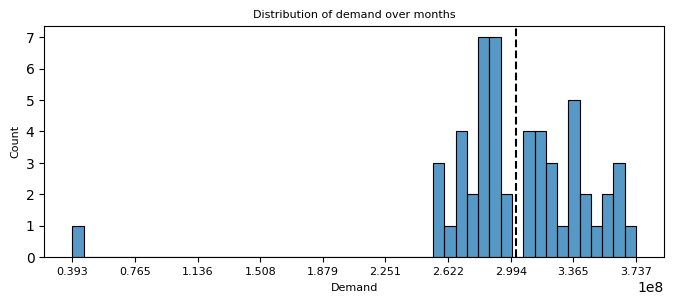

------ Starting from index: 53; Size: 53 ------


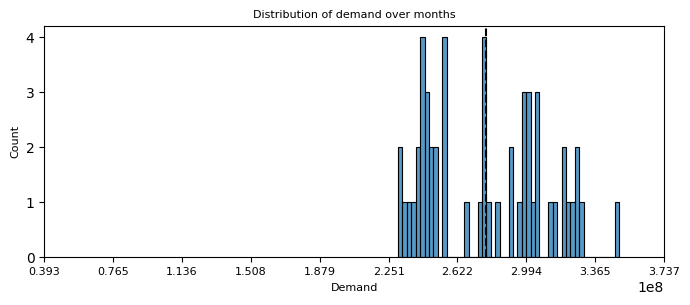

------ Starting from index: 106; Size: 52 ------


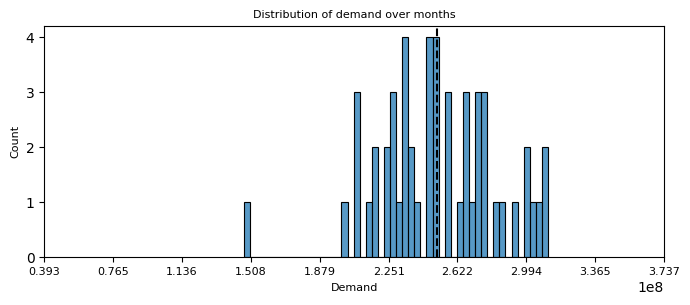

Mean values for each split: [302274503, 277753984, 251404884]
Variance values for each split: [2370052303908839, 1038201812480964, 1037596315504371] 

------ Starting from index: 0; Size: 956 ------


/opt/anaconda3/envs/bigpay/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


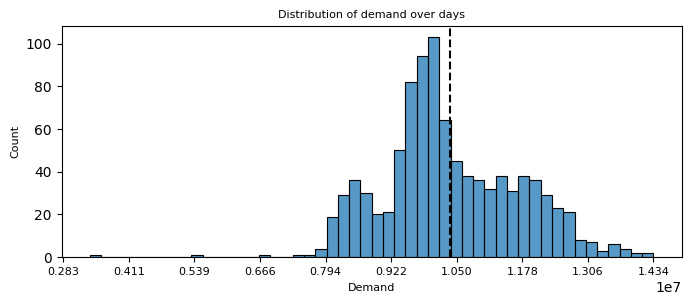

------ Starting from index: 956; Size: 955 ------


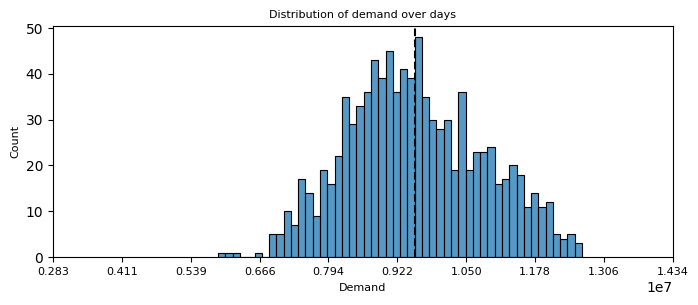

------ Starting from index: 1,911; Size: 955 ------


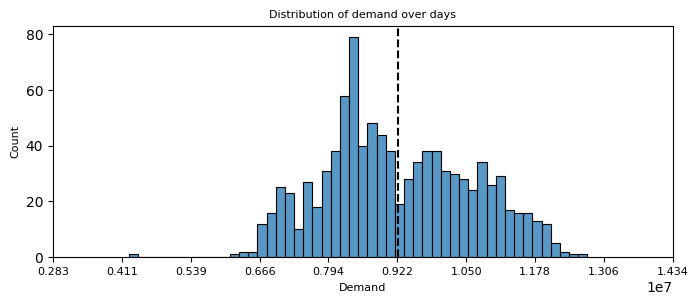

------ Starting from index: 2,866; Size: 955 ------


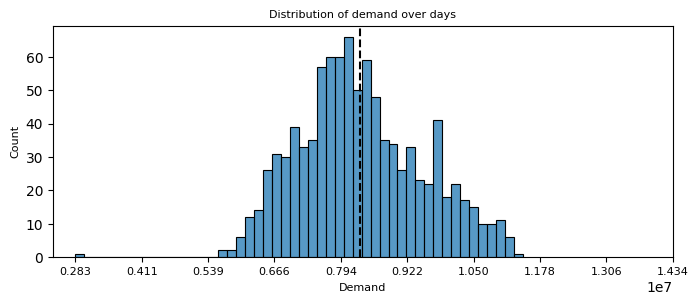

------ Starting from index: 3,821; Size: 955 ------


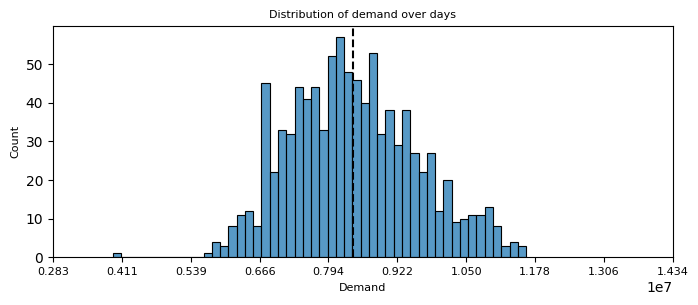

Mean values for each split: [10364707, 9548418, 9227844, 8320699, 8406602]
Variance values for each split: [1752562009639, 1591204884966, 1875821689983, 1432661712128, 1408552303831] 



In [117]:
# year, month, week 
for i in [('timestamp_year', 2), ('timestamp_month', 3), ('timestamp_day', 5)]:
    calculate_summary_stats(df=df, time_variable=i[0], variable='demand', n_splits=i[1])

Notes:

1. We see decreasing averages and variances in demand across the different scales of date aggregation, again, indicating non-stationarity

### Statistical tests

1. Conduct ADF and KPSS tests for significance

In [130]:
# function to calculate adf and kpss 
def calculate_adf_kpss(
        df: pd.DataFrame,
        time_variable: str, 
        variable: str
):
    """ 
    Calculate test statistics and p-values for adf and kpss tests

    """
    # check variables are available 
    assert time_variable in df.columns and variable in df.columns, "Specified variables not found in df"

    # filter df 
    df = df[(df[time_variable] > df[time_variable].min()) & (df[time_variable] < df[time_variable].max())]
    
    # groupby 
    df = df.groupby(time_variable)[variable].sum().to_frame()

    # adf 
    adf_ = adfuller(df[variable])
    adf_stat, adf_p = float(round(adf_[0],4)), float(round(adf_[1], 4))
    adf_results = (adf_stat, f"p-value: {adf_p}")

    # kpss
    kpss_ = kpss(df[variable])
    kpss_stat, kpss_p = float(round(kpss_[0],4)), float(round(kpss_[1], 4))
    kpss_results = (kpss_stat, f"p-value: {kpss_p}")

    print(f"------ {variable.capitalize()} over {time_variable.split('_')[-1]}s: ------")
    print(f"adf: {adf_results}")
    print(f"kpss: {kpss_results} \n")


In [131]:
# year, month, week
for i in ['timestamp_year', 'timestamp_month', 'timestamp_week']:
    calculate_adf_kpss(df=df, time_variable=i, variable='demand')

------ Demand over years: ------
adf: (-2.2456, 'p-value: 0.1901')
kpss: (0.6617, 'p-value: 0.017') 



/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_ = kpss(df[variable])


------ Demand over months: ------
adf: (-1.1158, 'p-value: 0.7087')
kpss: (1.4839, 'p-value: 0.01') 

------ Demand over weeks: ------
adf: (-5.586, 'p-value: 0.0')
kpss: (1.8251, 'p-value: 0.01') 



/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_ = kpss(df[variable])


Notes:

1. ADF results are showing us that demand in weeks is stationary (p < 0.05), while demand in months and years are not (p > 0.05)
2. KPSS results are showing us that demand in all scales are non-stationary (p < 0.05)
3. These statistical results imply slightly inconclusive results on the stationarity of the time-series (contradicting results on weeks)
4. In any case, taking the visuals, summary statistics and results of the statistical tests, I will consider the time-series as practically non-stationary with strong seasonality effects

Next steps:

1. Since the results are inconclusive and differ based on scale of date aggregation, I'll build separate models to forecast future weekly, monthly, and yearly demand
2. A Seasonal Autoregressive Integrated Moving Average (SARIMA) model would be best suited for this

### SARIMA 

### Gauging initial parameters

1. ARIMA(p,d,q)(P,D,Q)m
2. Where p = autoregressive (AR) component, non seasonal 
3. d = integrative (I) component, non seasonal 
4. q = moving average (MA) component, non seasonal 
5. P, D, Q indicate the same as above but on a seasonal scale, backshifted by m time points

### AR component (p & P) - PACF

In [97]:
# function for plotting acf and pacf
def plot_acf_pacf(
        df: pd.DataFrame,
        acf_pacf: str,
        time_variable: str, 
        variable: str,
        lags: int = 5
):
    """ 
    Plot ACF and PACF charts 

    """
    # check variable is available 
    assert time_variable in df.columns and variable in df.columns, "Specified variables not found in df"
    assert acf_pacf == 'acf' or acf_pacf == 'pacf', "To specify only acf or pacf for acf_pacf"

    # filter df 
    df = df[(df[time_variable] > df[time_variable].min()) & (df[time_variable] < df[time_variable].max())]

    # groupby 
    df = df.groupby(time_variable)[variable].sum().reset_index()[variable]
    
    # plot 
    if acf_pacf == 'pacf':
        plot_pacf(x=df, lags=lags)
        plt.xlabel(time_variable)
        plt.show()
    else:
        plot_acf(x=df, lags=lags)
        plt.xlabel(time_variable)
        plt.show()


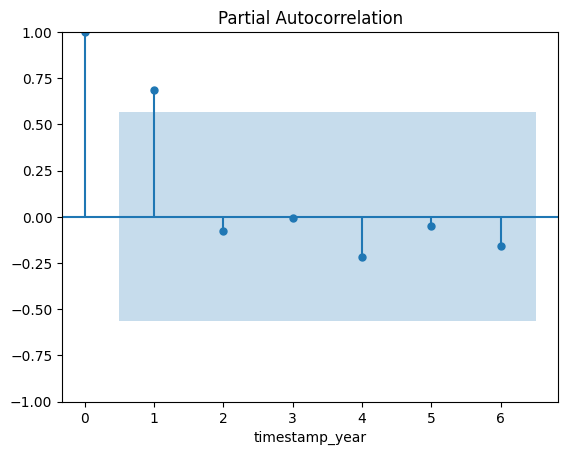

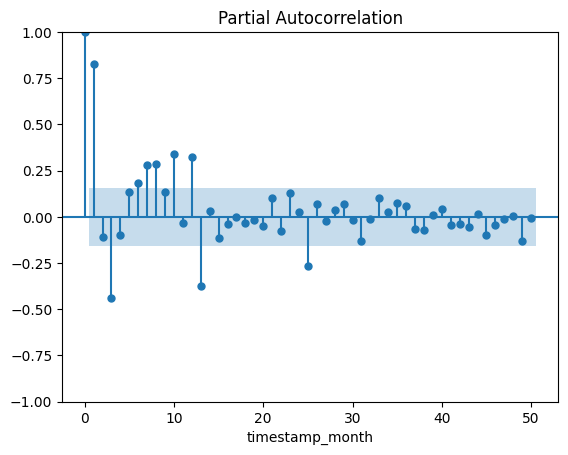

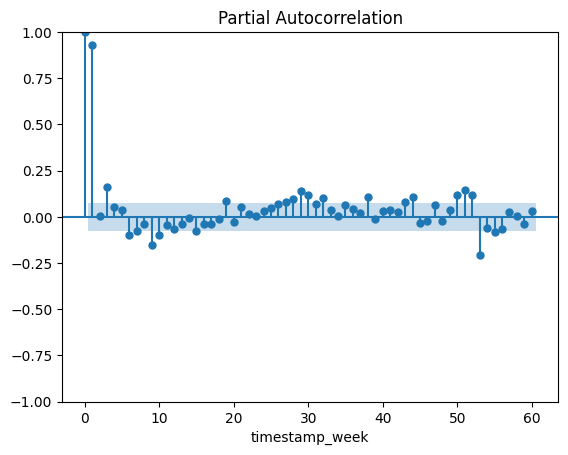

In [133]:
# year, month, week
for i in [('timestamp_year', 'pacf', 6), ('timestamp_month', 'pacf', 50), ('timestamp_week', 'pacf', 60)]:
    plot_acf_pacf(df=df, acf_pacf=i[1], time_variable=i[0], variable='demand', lags=i[2])

Notes:

1. For demand in years, the non-seasonal order of the AR component, p, is 1
2. For demand in months and weeks, it is also 1
3. These are common parameters to start off with in a SARIMA model without subjecting it to too much of an overfitting risk to unseen data

### I component (d & D) - Nth-order differencing

In [153]:
# function to perform nth-order differencing 
def n_differencing(
        df: pd.DataFrame,
        time_variable: str,
        variable: str,
        n: int
):
    """ 
    Return demand with nth-order differencing 

    """
    # check variable is available 
    assert time_variable in df.columns and variable in df.columns, "Specified variables not found in df"

    # filter df 
    df = df[(df[time_variable] > df[time_variable].min()) & (df[time_variable] < df[time_variable].max())]

    # groupby 
    df = df.groupby(time_variable)[variable].sum().reset_index()[[time_variable, variable]]

    # sort again, in case 
    df.sort_values(by=[time_variable], ascending=True, inplace=True)

    # differencing 
    df[f"differenced"] = df[variable].diff(periods=n)

    return df 

In [161]:
# try for 1 to 3 differencing, then perform adf and kpss 
n = [1, 2, 3]

for i in ['timestamp_year', 'timestamp_month', 'timestamp_week']:
    for j in n:
        print(f"------ Performing {j}-th order differencing on demand aggregated by {i}: ------")
        ndif_df = n_differencing(df=df, time_variable=i, variable='demand', n=j)
        calculate_adf_kpss(df=ndif_df, time_variable=i, variable='differenced')
        print('\n')

------ Performing 1-th order differencing on demand aggregated by timestamp_year: ------


/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ = kpss(df[variable])


------ Differenced over years: ------
adf: (-5.701, 'p-value: 0.0')
kpss: (0.2494, 'p-value: 0.1') 



------ Performing 2-th order differencing on demand aggregated by timestamp_year: ------


/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ = kpss(df[variable])


------ Differenced over years: ------
adf: (-2.0311, 'p-value: 0.2731')
kpss: (0.2142, 'p-value: 0.1') 



------ Performing 3-th order differencing on demand aggregated by timestamp_year: ------


/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ = kpss(df[variable])


------ Differenced over years: ------
adf: (-2.2023, 'p-value: 0.2054')
kpss: (0.1153, 'p-value: 0.1') 



------ Performing 1-th order differencing on demand aggregated by timestamp_month: ------


/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ = kpss(df[variable])


------ Differenced over months: ------
adf: (-6.4775, 'p-value: 0.0')
kpss: (0.0125, 'p-value: 0.1') 



------ Performing 2-th order differencing on demand aggregated by timestamp_month: ------


/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ = kpss(df[variable])


------ Differenced over months: ------
adf: (-4.5244, 'p-value: 0.0002')
kpss: (0.0136, 'p-value: 0.1') 



------ Performing 3-th order differencing on demand aggregated by timestamp_month: ------


/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ = kpss(df[variable])


------ Differenced over months: ------
adf: (-6.3934, 'p-value: 0.0')
kpss: (0.0142, 'p-value: 0.1') 



------ Performing 1-th order differencing on demand aggregated by timestamp_week: ------


/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ = kpss(df[variable])


------ Differenced over weeks: ------
adf: (-6.9595, 'p-value: 0.0')
kpss: (0.0196, 'p-value: 0.1') 



------ Performing 2-th order differencing on demand aggregated by timestamp_week: ------


/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ = kpss(df[variable])


------ Differenced over weeks: ------
adf: (-7.1639, 'p-value: 0.0')
kpss: (0.0176, 'p-value: 0.1') 



------ Performing 3-th order differencing on demand aggregated by timestamp_week: ------
------ Differenced over weeks: ------
adf: (-7.6214, 'p-value: 0.0')
kpss: (0.0411, 'p-value: 0.1') 





/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_39526/1491308463.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ = kpss(df[variable])


Notes:

1. A lag of 1 period in demand differencing seems to be enough in transforming demand in years, months and weeks from being non-stationary to stationary.

### MA component (q & Q) - ACF

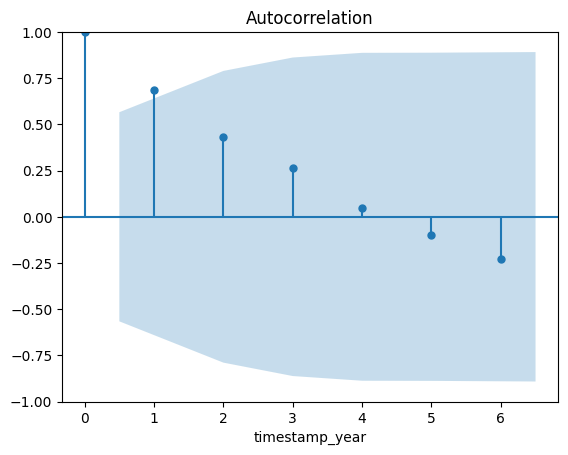

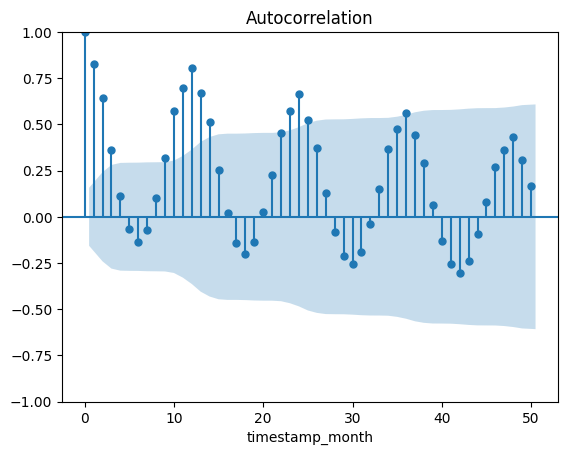

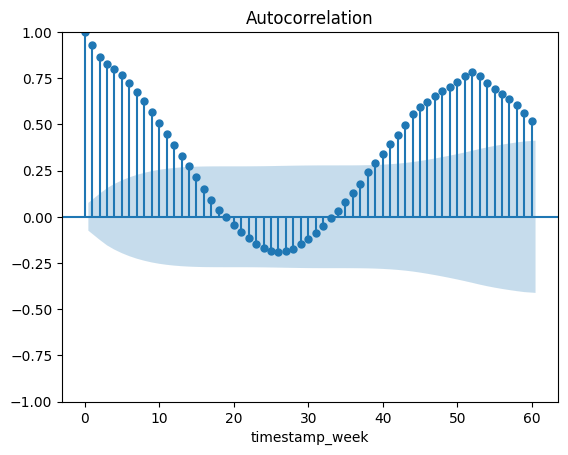

In [134]:
# year, month, week
for i in [('timestamp_year', 'acf', 6), ('timestamp_month', 'acf', 50), ('timestamp_week', 'acf', 60)]:
    plot_acf_pacf(df=df, acf_pacf=i[1], time_variable=i[0], variable='demand', lags=i[2])

Notes:

1. Again, we see evidence of seasonality here
2. The correlations are strong between current observations and q-lagged observations where q can go pretty high especially for demand in weeks
3. For demand in years, I will set m = 1
4. For months and weeks, m will be 12 and 52
5. Taking all the above together, we will initialise the SARIMA model with the following parameters:
    - Demand in years:
        - (p, d, q) = (1, 1, 1)
        - (P, D, Q)m = (0, 0, 0)0, indicating 0 seasonality to the time-series, which is the same as me fitting a non-seasonal ARIMA model
    
    - Demand in months:
        - (p, d, q) = (1, 1, 1)
        - (P, D, Q)m = (1, 1, 1)12

    - Demand in weeks:
        - (p, d, q) = (1, 1, 1)
        - (P, D, Q)m = (1, 1, 1)52

### Model

1. Define `SARIMA` class with the following properties:
    - data 
    - time-series scale (year, month, week)
    - target variable (demand)

2. To have the following modules:
    - split_data()
        - to split data into 80:20 train:test set 
    - fit_model()
        - to fit model to training set with specified parameters p,d,q,P,D,Q,m
        - to also include the goodness-of-fit evaluation
    - predict_test()
        - to visualise predictive accuracy of model by plotting actual and predicted demand 
        - part of model prediction evaluation
    - predict_demand()
        - to forecast demand on specified date

3. The class should also be able to handle the following:
    - training data should not include the very first date as it is an outlier 

4. Limitations:
    - not evaluated on cross-validation
    - fits only with a single model SARIMA
    - no search was done to potentially optimise for better model parameters, i.e. no model fine-tuning was done
    - suitability for using SARIMA on this particular dataset is made on the satisfaction of certain assumptions showed above (visualisation, summary stats, statistical tests on stationarity of time-series, seasonality etc) 
    - the accuracy of predicting future demand, using the trained SARIMA model, depends on how much the training set's properties on trend, seasonality, hold constant over time

In [501]:
# SARIMA predictor 
class SARIMA:
    def __init__(self, csv_path: str = './dataset/gridwatch-all.csv', time_variable: str = 'timestamp', time_scale: str = 'year', target_variable: str = 'demand'):
        # import csv and handle wrong path
        try: 
            self.data = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"Specified path {csv_path} does not exist")
            return
        # validate time_scale argument
        if time_scale not in ['year', 'month', 'week']:
            raise ValueError(f"Invalid time_scale argument. Must be one of the following: year, month or week")
        self.time_variable = time_variable
        self.time_variable_ = time_variable + '_' + time_scale
        self.time_scale = time_scale 
        self.target_variable = target_variable
    
    def preprocess_data(self):
        """ 
        Preprocess data by standardising column names, converting timestamp to datetime format and proper date aggregation.

        Returns: 
        Preprocessed self.data

        """
        self.data.columns = [i.strip() for i in self.data.columns]

        self.data[self.time_variable] = pd.to_datetime(self.data[self.time_variable])

        if self.time_scale == 'year':
            self.data[self.time_variable_] = self.data[self.time_variable].dt.strftime('%Y-01-01')
        elif self.time_scale == 'month':
            self.data[self.time_variable_] = self.data[self.time_variable].dt.strftime('%Y-%m-01')
        elif self.time_scale == 'week':
            self.data[self.time_variable_] = (self.data[self.time_variable] - pd.to_timedelta(self.data[self.time_variable].dt.weekday, unit='D')).dt.strftime('%Y-%m-%d')

    def split_data(self, test_size: float = 0.2, random_state: int = 1):
        """ 
        Split time-series into train and test sets. Includes clean up of data before split. 

        Parameters:
        test_size -> Proportion of data to be used as test set 
        random_state -> Replicability

        Returns:
        Train and test data sets 

        """
        # remove very first outlier time point 
        outlier = self.data[self.time_variable_].min() 
        self.data = self.data[self.data[self.time_variable_] > outlier] 

        # clean up 
        self.data.sort_values(by=self.time_variable_, ascending=True, inplace=True)
        self.data[self.time_variable_] = pd.to_datetime(self.data[self.time_variable_]) 
        self.data.set_index(self.time_variable_, inplace=True)

        # groupby 
        self.data = self.data.groupby(self.time_variable_)[self.target_variable].sum().reset_index()

        # split
        train_data, test_data = train_test_split(self.data, shuffle=False, test_size=test_size, random_state=random_state)
         
        return train_data, test_data
    
    def fit_model(self, train_data: pd.DataFrame, p: int, d: int, q: int, P: int, D: int, Q: int, m: int):
        """ 
        Fit a SARIMA model to training data 

        Parameters: 
        train_data -> Training df 
        p -> Order of non-seasonal AR 
        d -> Order of non-seasonal I
        q -> Order of non-seasonal MA 
        P -> Order of seasonal AR 
        D -> Order of seasonal I 
        Q -> Order of seasonal MA 
        m -> Sesonal period 

        Returns:
        Results of fitted model in terms of residual plots and summary statistics of model estimates

        """
        # fit 
        self.model = SARIMAX(train_data[self.target_variable], order=(p, d, q), seasonal_order=(P, D, Q, m))
        self.model_fit = self.model.fit(disp=False) 

        # evaluate goodness of fit 
        residuals = self.model_fit.resid 

        # plot 
        print(f"Visual model diagnostics on goodness-of-fit on training set: \n")
        fig, ax = plt.subplots(1, 2, figsize=(8, 3))
        residuals.plot(ax=ax[0]) # residuals 
        ax[0].set_title('Residuals plot', fontsize=10)
        ax[0].set_xticks([])
        ax[0].set_xlabel(self.time_variable_, fontsize=10)
        sm.qqplot(residuals, line='s', ax=ax[1]) # qq plot of residuals 
        ax[1].set_title('Q-Q plot of residuals', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        print('\n')

        # model summary statistics 
        print(f"Summary statistics of model estimates: \n")
        print(f"{self.model_fit.summary()} \n")
    
    def predict_data(self, test_data: pd.DataFrame, alpha_ci: float):
        """ 
        Use fitted model to predict test set, and evaluate predictions through visual means 

        Parameters:
        test_data -> Test set 
        alpha_ci -> Alpha where confidence interval = 1 - alpha

        Returns:
        Chart of actual and predicted time-series on train and test set

        """
        # clean up 
        self.data.set_index(self.time_variable_, inplace=True)

        # predict train and test set 
        pred = self.model_fit.forecast(len(self.data))

        # confidence interval 
        ci_pred = self.model_fit.get_forecast(steps=len(pred), alpha=alpha_ci).conf_int()

        # plot
        plt.figure(figsize=(8, 3))
        plt.plot(self.data.index, self.data[self.target_variable], label='Actual')
        plt.plot(self.data.index, pred, label='Predicted')
        if alpha_ci == 0:
            pass
        else:
            plt.fill_between(self.data.index, 
                            ci_pred['lower demand'], 
                            ci_pred['upper demand'],
                            color='gray', 
                            alpha=0.3, 
                            label=f"{100-alpha_ci*100}% Confidence Interval")
        plt.title('Forecast of train and test set', fontsize=10)
        plt.xlabel(f"{self.time_variable_}", fontsize=10)
        plt.ylabel(f"Demand", fontsize=10)
        plt.legend()
        plt.axvline(x=test_data[self.time_variable_].min(), color='black', linestyle='--')
        plt.show() 
        print('\n')  
    
    def forecast(self, forecast_date: str, alpha_ci: float):
        """ 
        Predict demand of specified time, depending on specified date aggregation (year, month, week).
        For example, if date = '2024-05-31' and time_variable = 'timestamp_month', then demand 
        for the whole month of 2024-05-01 will be forecasted.

        Paramaters:
        date -> Date in string format 
        alpha_ci -> Alpha value

        Returns:
        Forecasted value

        """
        # ensure correct format of date 
        try: 
            datetime.strptime(forecast_date, '%Y-%m-%d')
        except ValueError:
            print("Date to be forecasted is invalid. Please ensure it is in the following format: '%Y-%m-%d', with the correct months and days")
            return 

        # convert to appropriate timestamp
        forecast_date = pd.Timestamp(forecast_date)

        if 'year' in self.time_variable_:
            forecast_date = forecast_date.replace(month=1, day=1)
        elif 'month' in self.time_variable_:
            forecast_date = forecast_date.replace(day=1) 
        elif 'week' in self.time_variable_:
            forecast_date = forecast_date - pd.Timedelta(days=forecast_date.weekday())
    

        # convert to the same format as trained data 
        forecast_date_df = pd.DataFrame(index=[forecast_date])
        
        print(f"------ Forecasting for {self.time_scale} {forecast_date} ------ \n")
    
        forecasted_value = self.model_fit.forecast(len(forecast_date_df))
        forecasted_ci = self.model_fit.get_forecast(steps=len(forecasted_value), alpha=alpha_ci).conf_int()

        print(f"Sum of Demand: {float(forecasted_value.values[0])}")
        print(f"{int(100-alpha_ci*100)}% Confidence Interval: {forecasted_ci.values[0]}")
        

Visual model diagnostics on goodness-of-fit on training set: 



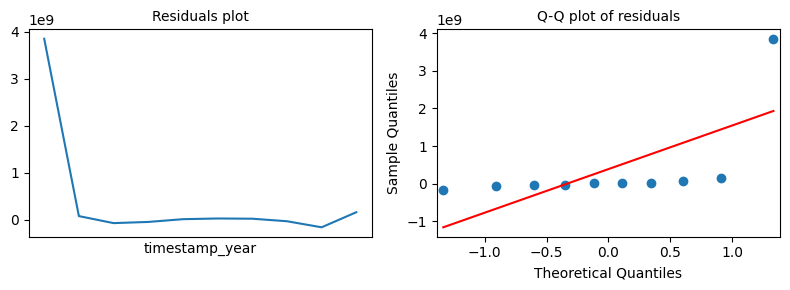



Summary statistics of model estimates: 

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                   10
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -177.655
Date:                Sun, 30 Jun 2024   AIC                            361.310
Time:                        18:52:35   BIC                            361.901
Sample:                             0   HQIC                           360.033
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8779      0.164      5.360      0.000       0.557       1.199
ma.L1         -0.9189      0.146     -6.290      0.000      -1.205      -0.633
sigma2   

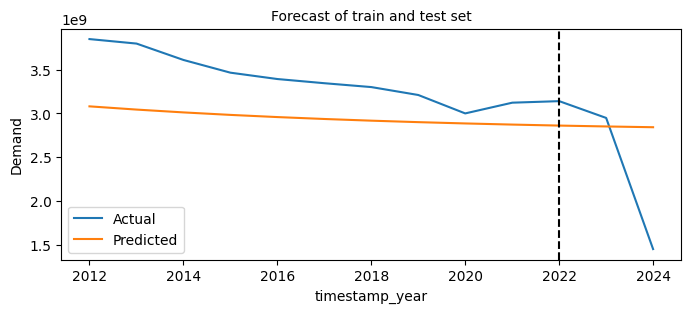



Date to be forecasted is invalid. Please ensure it is in the following format: '%Y-%m-%d'


In [504]:
# fit and predict demand 
model = SARIMA(csv_path='./dataset/gridwatch-all.csv', time_variable='timestamp', time_scale='year', target_variable='demand')
model.preprocess_data()
train_df, test_df = model.split_data(test_size=0.2, random_state=1)
model.fit_model(train_data=train_df, p=1, d=1, q=1, P=0, D=0, Q=0, m=0)
model.predict_data(test_data=test_df, alpha_ci=0)
model.forecast(forecast_date='2024-05-01', alpha_ci=0.05)